# Final Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

## Words go here lol

# OBTAIN

## Import tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import mlxtend
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

## King County dataset

In [2]:
# read data
kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 
              'sqft_basement', 'yr_built']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\kc_house_data.csv', parse_dates = ['date'], dtype=kc_dtypes)

kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float, errors='ignore')
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_habitable'] = (kc_data['sqft_above']+1)*(kc_data['sqft_basement']+1)

In [3]:
#drop unnessecary columns and fix data
kc_data = kc_data.drop('sqft_living', 1).drop('sqft_lot', 1).drop('id', 1).drop('date', 1).drop('sqft_above',1).drop('sqft_basement',1)

#look for outliers, in bedrooms, we can clearly see a single outlier, for other columns, filtering by z score will be easiest 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so it looks like a typo
# will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [4]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data['waterfront'] = kc_data['waterfront'].fillna(0)
kc_data['view'] = kc_data['view'].fillna(0)
kc_data['yr_renovated'] = kc_data['yr_renovated'].fillna(0)

In [5]:
#Convert to integer for whole number year
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

In [6]:
dumm = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [7]:
kc_data = kc_data.rename({'cond_2.0':'con2', 'cond_3.0':'con3','cond_4.0':'con4','cond_5.0':'con5'},axis=1)
kc_data = kc_data.rename({ 'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({ 'gra_4': 'grd4', 'gra_5':'grd5', 'gra_6':'grd6',
       'gra_7':'grd7', 'gra_8':'grd8', 'gra_9':'grd9', 'gra_10':'grd10', 'gra_11':'grd11', 'gra_12':'grd12', 'gra_13':'grd13'},axis=1)

In [8]:
zips = []

for zipcode in kc_data.zipcode:
    zips.append(zipcode)
    
zips = list(set(zips))
zips.sort()

In [9]:
#would be a bad idea to add 70 dummies to our columns so instead we're binning our zipcodes by 5 
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:5], value= 'zip1')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:10], value= 'zip2')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:15], value= 'zip3')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:20], value= 'zip4')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:25], value= 'zip5')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:30], value= 'zip6')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:35], value= 'zip7')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:40], value= 'zip8')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:45], value= 'zip9')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:50], value= 'zip10')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:55], value= 'zip11')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:60], value= 'zip12')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:65], value= 'zip13')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[:70], value= 'zip14')

In [10]:
years = []

for year in kc_data.yr_built:
    years.append(year)
    
years = list(set(years))
years.sort()

In [11]:
#gonna do the same for year built by 20 years, will give us 6 new columns, may be illuminating 
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:20], value= 'thru20')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:40], value= 'thru40')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:60], value= 'thru60')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:80], value= 'thru80')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:100], value= 'thru2000')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[:120], value= 'thru2020')

In [12]:
dumm = pd.get_dummies(kc_data['zipcode'], prefix=None, drop_first=True)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['yr_built'], prefix=None, drop_first=True)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [13]:
kc_data =  kc_data.loc[kc_data['bathrooms'] > 1]
kc_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'grd13', 'zip10', 'zip11', 'zip12', 'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80'], dtype='object')

In [14]:
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 
                   'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 
                   'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'grd13', 'zip10', 'zip11', 'zip12', 
                   'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9',
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']].copy()

## Dataframe Info

In [15]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17671 entries, 1 to 21595
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           17671 non-null  float64
 1   bedrooms        17671 non-null  int32  
 2   bathrooms       17671 non-null  float64
 3   floors          17671 non-null  float64
 4   waterfront      17671 non-null  float64
 5   yr_renovated    17671 non-null  int32  
 6   lat             17671 non-null  float64
 7   long            17671 non-null  float64
 8   sqft_living15   17671 non-null  int64  
 9   sqft_lot15      17671 non-null  int64  
 10  sqft_total      17671 non-null  int32  
 11  sqft_habitable  17671 non-null  float64
 12  con2            17671 non-null  int32  
 13  con3            17671 non-null  int32  
 14  con4            17671 non-null  int32  
 15  con5            17671 non-null  int32  
 16  view1           17671 non-null  int32  
 17  view2           17671 non-null 

## Check for NaN

In [16]:
kc_data.isna().sum()

price             0
bedrooms          0
bathrooms         0
floors            0
waterfront        0
yr_renovated      0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
sqft_total        0
sqft_habitable    0
con2              0
con3              0
con4              0
con5              0
view1             0
view2             0
view3             0
view4             0
grd4              0
grd5              0
grd6              0
grd7              0
grd8              0
grd9              0
grd10             0
grd11             0
grd12             0
grd13             0
zip10             0
zip11             0
zip12             0
zip13             0
zip14             0
zip2              0
zip3              0
zip4              0
zip5              0
zip6              0
zip7              0
zip8              0
zip9              0
thru2000          0
thru2020          0
thru40            0
thru60            0
thru80            0
dtype: int64

## For Loop - Value Counts

In [17]:
for col in kc_data.columns:
    try:
        print(col, kc_data[col].value_counts()[:5])
    except:
        print(col, kc_data[col].value_counts())
    print('\n')

price 450000.0    143
550000.0    133
500000.0    128
350000.0    124
525000.0    115
           ... 
176250.0      1
575575.0      1
837700.0      1
575550.0      1
884744.0      1
Name: price, Length: 3223, dtype: int64


bedrooms 3    8029
4    6554
5    1558
2    1174
6     266
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
4.75      23
5.00      21
Name: bathrooms, dtype: int64


floors 2.0    8125
1.0    7493
1.5    1281
3.0     607
2.5     158
3.5       7
Name: floors, dtype: int64


waterfront 0.0    17540
1.0      131
Name: waterfront, dtype: int64


yr_renovated 0       17035
2014       64
2003       30
2000       29
2013       27
Name: yr_renovated, dtype: int64


lat 47.6904    15
47.5491    15
47.6624    14
47.6647    14
47.6651    14
           ..
47.4317     1
47.6137     1
47.6311     1
47.2922     1
47.2715  

## Drop Condition Has No Values Present

## Summary

In [18]:
kc_data.describe().round(3)

,price,bedrooms,bathrooms,floors,waterfront,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_total,sqft_habitable,con2,con3,con4,con5,view1,view2,view3,view4,grd4,grd5,grd6,grd7,grd8,grd9,grd10,grd11,grd12,grd13,zip10,zip11,zip12,zip13,zip14,zip2,zip3,zip4,zip5,zip6,zip7,zip8,zip9,thru2000,thru2020,thru40,thru60,thru80
count,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,1.767100e+04,1.767100e+04,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000,17671.000
mean,583459.935,3.538,2.365,1.579,0.007,71.888,47.560,-122.201,2105.546,13374.127,4.045468e+07,5.840058e+05,0.005,0.668,0.248,0.079,0.017,0.049,0.027,0.017,0.000,0.002,0.034,0.389,0.335,0.148,0.064,0.023,0.005,0.001,0.061,0.075,0.072,0.046,0.053,0.064,0.053,0.081,0.089,0.106,0.091,0.073,0.071,0.250,0.267,0.058,0.136,0.240
std,386521.736,0.848,0.617,0.550,0.086,372.070,0.139,0.141,683.272,28481.057,1.168640e+08,1.124638e+06,0.067,0.471,0.432,0.269,0.129,0.215,0.163,0.128,0.008,0.046,0.181,0.488,0.472,0.355,0.245,0.149,0.071,0.027,0.240,0.263,0.258,0.210,0.224,0.245,0.225,0.273,0.284,0.308,0.288,0.261,0.256,0.433,0.442,0.234,0.343,0.427
min,107000.000,1.000,1.250,1.000,0.000,0.000,47.156,-122.519,399.000,651.000,-1.965487e+09,5.910000e+02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,350000.000,3.000,1.750,1.000,0.000,0.000,47.463,-122.317,1600.000,5102.000,1.010502e+07,1.891000e+03,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,490000.000,3.000,2.500,2.000,0.000,0.000,47.576,-122.207,1970.000,7725.000,1.615104e+07,3.131000e+03,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,690000.000,4.000,2.500,2.000,0.000,0.000,47.676,-122.111,2490.000,10400.000,2.776518e+07,8.804610e+05,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
max,7700000.000,11.000,8.000,3.500,1.000,2015.000,47.778,-121.319,6210.000,871200.000,2.031076e+09,3.887684e+07,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# EXPLORE

## Histogram

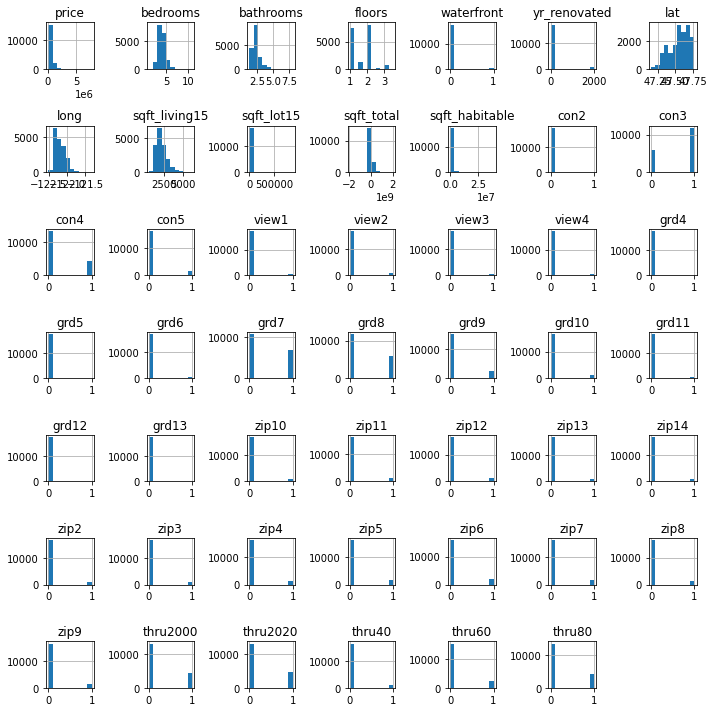

In [19]:
kc_data.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

In [20]:
# fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));
# print(type(fig))

## Heatmap

Text(0.5, 1.0, 'Correlations')

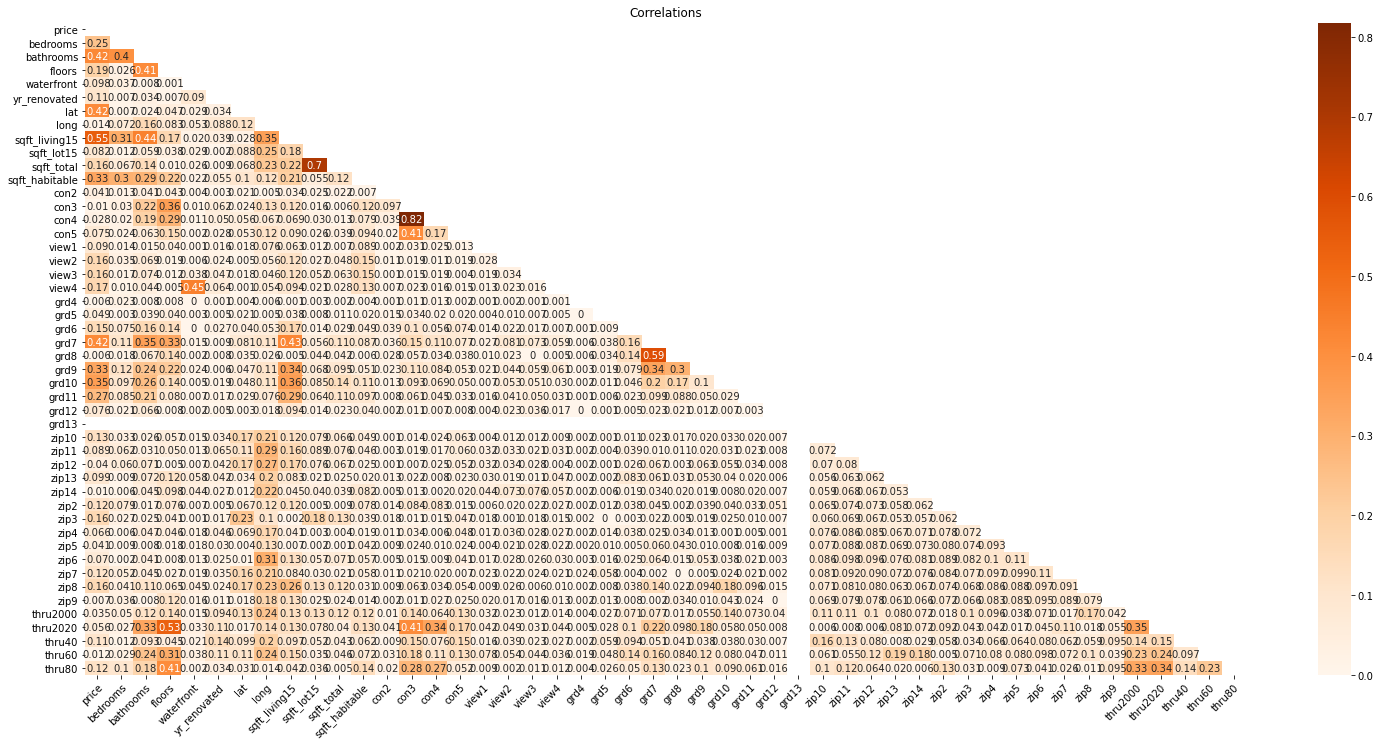

In [153]:
fig, ax = plt.subplots(figsize=(26,12))

corr = kc_data.corr().abs().round(3)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')

# MODEL

## Initial Model on Price

In [22]:
outcome = 'price'
x_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 
                   'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 
                   'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'zip10', 'zip11', 'zip12', 
                   'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9',
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']

In [23]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1111.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:14:42   Log-Likelihood:            -2.4053e+05
No. Observations:               17671   AIC:                         4.812e+05
Df Residuals:                   17625   BIC:                         4.815e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.887e+07    2.1e+06    -13.752      0.000    -3.3e+07   -2.48e+07
bedrooms        4212.8413   2089.089      2.017      0.044     118.021    8307.662
bathrooms       7.179e+04   3677.602     19.521      0.000    6.46e+04     7.9e+04
floors          2.101e+04   3951.719      5.317      0.000    1.33e+04    2.88e+04
waterfront      6.658e+05   2.12e+04     31.376      0.000    6.24e+05    7.07e+05
yr_renovated      46.3448      4.328     10.709      0.000      37.862      54.827
lat             6.228e+05   1.25e+04     49.644      0.000    5.98e+05    6.47e+05
long           -1.525e+04   1.64e+04     -0.931      0.352   -4.74e+04    1.69e+04
sqft_living15     82.0855      3.480     23.590      0.000      75.265      88.906
sqft_lot15         0.0459      0.071      0.649      0.516      -0.093       0.184
sqft_total      3.719e-05   1.73e-05      2.155      0.031    3.37e-06     7.1e-05
sqft_habitable     0.0486      0.002     28.681      0.000       0.045       0.052
con2            1.695e+04   2.23e+04      0.760      0.447   -2.68e+04    6.07e+04
con4            5.278e+04   4039.577     13.067      0.000    4.49e+04    6.07e+04
con5            9.032e+04   6218.132     14.525      0.000    7.81e+04    1.03e+05
view1           1.131e+05   1.18e+04      9.582      0.000       9e+04    1.36e+05
view2           6.804e+04   7195.336      9.456      0.000    5.39e+04    8.21e+04
view3            1.22e+05   9619.124     12.682      0.000    1.03e+05    1.41e+05
view4           2.332e+05   1.46e+04     16.018      0.000    2.05e+05    2.62e+05
grd4           -2.322e+06   2.06e+05    -11.283      0.000   -2.73e+06   -1.92e+06
grd5           -2.452e+06    6.6e+04    -37.148      0.000   -2.58e+06   -2.32e+06
grd6           -2.394e+06   5.78e+04    -41.405      0.000   -2.51e+06   -2.28e+06
grd7           -2.324e+06   5.71e+04    -40.733      0.000   -2.44e+06   -2.21e+06
grd8            -2.25e+06   5.68e+04    -39.598      0.000   -2.36e+06   -2.14e+06
grd9           -2.104e+06   5.67e+04    -37.142      0.000   -2.22e+06   -1.99e+06
grd10          -1.909e+06   5.66e+04    -33.730      0.000   -2.02e+06    -1.8e+06
grd11           -1.64e+06   5.69e+04    -28.844      0.000   -1.75e+06   -1.53e+06
grd12          -1.184e+06   5.93e+04    -19.947      0.000    -1.3e+06   -1.07e+06
zip10          -4.984e+04   9294.934     -5.362      0.000   -6.81e+04   -3.16e+04
zip11          -1.137e+05   8931.698    -12.725      0.000   -1.31e+05   -9.62e+04
zip12          -1.895e+05   8902.993    -21.289      0.000   -2.07e+05   -1.72e+05
zip13          -2.393e+05   9526.682    -25.117      0.000   -2.58e+05   -2.21e+05
zip14          -1.866e+05   9175.824    -20.332      0.000   -2.05e+05   -1.69e+05
zip2           -1.369e+05   8756.392    -15.629      0.000   -1.54e+05    -1.2e+05
zip3        

## Regression Results

In [24]:
model.params.sort_values()

Intercept        -2.887344e+07
grd5             -2.452056e+06
grd6             -2.394279e+06
grd7             -2.324480e+06
grd4             -2.322449e+06
grd8             -2.249959e+06
grd9             -2.104467e+06
grd10            -1.908573e+06
grd11            -1.639882e+06
grd12            -1.183793e+06
zip13            -2.392825e+05
zip8             -2.119632e+05
zip12            -1.895324e+05
zip14            -1.865645e+05
zip7             -1.818281e+05
thru2000         -1.762230e+05
zip3             -1.761692e+05
zip4             -1.689366e+05
thru80           -1.529825e+05
thru2020         -1.523652e+05
zip2             -1.368549e+05
zip9             -1.155113e+05
zip11            -1.136577e+05
zip6             -1.065674e+05
zip5             -9.775991e+04
thru60           -7.611384e+04
zip10            -4.984250e+04
thru40           -2.442008e+04
long             -1.525273e+04
sqft_total        3.719229e-05
sqft_lot15        4.587903e-02
sqft_habitable    4.858598e-02
yr_renov

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              6369.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:17:25   Log-Likelihood:                         -32656.
No. Observations:                2777   AIC:                                  6.537e+04
Df Residuals:                    2748   BIC:                                  6.554e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        4361.6377    911.743      4.784      0.000    2573.867    6149.408
lat             6.068e+04   7057.753      8.597      0.000    4.68e+04    7.45e+04
long            2.211e+04   2739.047      8.073      0.000    1.67e+04    2.75e+04
sqft_living15     25.5819      1.893     13.511      0.000      21.869      29.294
sqft_total      8.299e-05   2.57e-05      3.225      0.001    3.25e-05       0.000
sqft_habitable     0.0119      0.002      7.362      0.000       0.009       0.015
con2           -2.909e+04   5758.117     -5.053      0.000   -4.04e+04   -1.78e+04
con4            5925.0431   1464.834      4.045      0.000    3052.757    8797.330
con5             1.09e+04   2774.729      3.927      0.000    5456.839    1.63e+04
view1           1.611e+04   1.19e+04      1.355      0.175   -7196.989    3.94e+04
view2           1.548e+04   6030.080      2.568      0.010    3658.813    2.73e+04
grd4             4.13e-08   4.67e-08      0.885      0.376   -5.02e-08    1.33e-07
grd10          -2.855e-08   3.23e-08     -0.885      0.376   -9.18e-08    3.47e-08
grd11          -2.441e-08   2.76e-08     -0.885      0.376   -7.85e-08    2.97e-08
grd12             2.1e-09   2.37e-09      0.887      0.375   -2.54e-09    6.74e-09
zip10           1424.2152   5699.626      0.250      0.803   -9751.769    1.26e+04
zip11           -406.1711   4530.644     -0.090      0.929   -9289.982    8477.640
zip12           1.033e+04   4657.950      2.219      0.027    1201.393    1.95e+04
zip13           7610.0425   3001.028      2.536      0.011    1725.544    1.35e+04
zip14            563.2539   2685.038      0.210      0.834   -4701.643    5828.151
zip2           -3723.8463   5963.301     -0.624      0.532   -1.54e+04    7969.158
zip3            4249.0245   2173.345      1.955      0.051     -12.530    8510.579
zip4            3414.4566   2533.696      1.348      0.178   -1553.685    8382.598
zip5            5745.7998   2627.952      2.186      0.029     592.838    1.09e+04
zip6            -768.8571   2644.758     -0.291      0.771   -5954.771    4417.057
zip7            1.091e+04   2774.014      3.932      0.000    5467.086    1.63e+04
zip8            2.755e+04   1.21e+04      2.275      0.023    3806.298    5.13e+04
zip9            4995.0412   2692.952      1.855      0.064    -285.374    1.03e+04
thru2000        1.928e+04   4614.903      4.178      0.000    1.02e+04    2.83e+04
thru2020        2.909e+04   4758.228      6.113      0.000    1.98e+04    3.84e+04
thru40          9153.4647   5490.596      1.667      0.096   -1612.648    1.99e+04
thru60          4073.9751   4646.205      0.877      0.381   -5036.431    1.32e+04
thru80          5519.0179   4517.364      1.222      0.222   -3338.753    1.44e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              8699.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:17:25   Log-Likelihood:                     -1.5417e+05
No. Observations:               12005   AIC:                                  3.084e+05
Df Residuals:                   11961   BIC:                                  3.087e+05
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        6398.6408   1185.755      5.396      0.000    4074.369    8722.912
bathrooms       2.432e+04   2238.913     10.862      0.000    1.99e+04    2.87e+04
floors          6610.9719   2283.919      2.895      0.004    2134.120    1.11e+04
waterfront      1.063e+05   2.27e+04      4.685      0.000    6.18e+04    1.51e+05
yr_renovated      13.3019      2.678      4.967      0.000       8.053      18.551
lat             4.015e+05   7392.426     54.310      0.000    3.87e+05    4.16e+05
long             7.58e+04   9294.524      8.155      0.000    5.76e+04     9.4e+04
sqft_living15     60.0511      2.200     27.296      0.000      55.739      64.363
sqft_lot15         0.1791      0.043      4.165      0.000       0.095       0.263
sqft_total      8.667e-05    1.2e-05      7.233      0.000    6.32e-05       0.000
sqft_habitable     0.0094      0.001      6.663      0.000       0.007       0.012
con2            8612.3281   1.39e+04      0.619      0.536   -1.87e+04    3.59e+04
con4            2.864e+04   2309.450     12.400      0.000    2.41e+04    3.32e+04
con5             5.44e+04   3567.300     15.249      0.000    4.74e+04    6.14e+04
view1           5.296e+04   7131.203      7.426      0.000     3.9e+04    6.69e+04
view2           4.485e+04   4319.273     10.383      0.000    3.64e+04    5.33e+04
view3            5.76e+04   6417.525      8.976      0.000     4.5e+04    7.02e+04
view4           7.793e+04   1.35e+04      5.762      0.000    5.14e+04    1.04e+05
grd4           -9.547e+06   1.18e+06     -8.061      0.000   -1.19e+07   -7.23e+06
grd5            -9.58e+06   1.18e+06     -8.107      0.000   -1.19e+07   -7.26e+06
grd6           -9.556e+06   1.18e+06     -8.091      0.000   -1.19e+07   -7.24e+06
grd7           -9.493e+06   1.18e+06     -8.037      0.000   -1.18e+07   -7.18e+06
grd8           -9.436e+06   1.18e+06     -7.987      0.000   -1.18e+07   -7.12e+06
grd9           -9.365e+06   1.18e+06     -7.927      0.000   -1.17e+07   -7.05e+06
grd10          -9.316e+06   1.18e+06     -7.885      0.000   -1.16e+07      -7e+06
grd11          -9.292e+06   1.18e+06     -7.862      0.000   -1.16e+07   -6.98e+06
grd12           5.573e-07   6.97e-08      7.999      0.000    4.21e-07    6.94e-07
zip10           1.818e+04   6386.210      2.847      0.004    5665.785    3.07e+04
zip11           1.885e+04   6123.428      3.078      0.002    6843.351    3.08e+04
zip12          -5.006e+04   6015.926     -8.321      0.000   -6.18e+04   -3.83e+04
zip13          -8.212e+04   6433.031    -12.766      0.000   -9.47e+04   -6.95e+04
zip14          -4.054e+04   6558.267     -6.182      0.000   -5.34e+04   -2.77e+04
zip2           -7164.2160   6099.842     -1.174      0.240   -1.91e+04    4792.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              945.9
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:17:25   Log-Likelihood:                         -40912.
No. Observations:                2889   AIC:                                  8.191e+04
Df Residuals:                    2846   BIC:                                  8.217e+04
Df Model:                          43                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms       -3558.2034   8512.278     -0.418      0.676   -2.02e+04    1.31e+04
bathrooms       1.122e+05    1.2e+04      9.370      0.000    8.88e+04    1.36e+05
floors           4.66e+04   1.73e+04      2.696      0.007    1.27e+04    8.05e+04
waterfront      7.256e+05   4.28e+04     16.957      0.000    6.42e+05     8.1e+05
yr_renovated      46.7563     13.494      3.465      0.001      20.296      73.216
lat            -2.849e+05   1.07e+05     -2.657      0.008   -4.95e+05   -7.47e+04
long           -1.326e+05   4.18e+04     -3.175      0.002   -2.14e+05   -5.07e+04
sqft_living15     88.9499     11.071      8.034      0.000      67.241     110.659
sqft_lot15        -0.5062      0.229     -2.211      0.027      -0.955      -0.057
sqft_total      1.688e-05   4.19e-05      0.403      0.687   -6.53e-05    9.91e-05
sqft_habitable     0.0466      0.004     12.178      0.000       0.039       0.054
con2            1.614e+04   1.58e+05      0.102      0.919   -2.94e+05    3.26e+05
con4            9.593e+04   1.88e+04      5.100      0.000     5.9e+04    1.33e+05
con5            1.014e+05   2.45e+04      4.133      0.000    5.33e+04     1.5e+05
view1           9.435e+04   3.38e+04      2.793      0.005    2.81e+04    1.61e+05
view2           5.199e+04   2.15e+04      2.416      0.016    9796.802    9.42e+04
view3           1.014e+05   2.52e+04      4.024      0.000     5.2e+04    1.51e+05
view4           2.097e+05   3.13e+04      6.688      0.000    1.48e+05    2.71e+05
grd4            5.242e-09   4.98e-09      1.053      0.293   -4.52e-09     1.5e-08
grd5             3.73e-09   2.56e-09      1.454      0.146    -1.3e-09    8.76e-09
grd6           -2.137e+06   1.78e+05    -11.993      0.000   -2.49e+06   -1.79e+06
grd7           -2.116e+06   1.09e+05    -19.471      0.000   -2.33e+06    -1.9e+06
grd8           -2.012e+06   1.04e+05    -19.346      0.000   -2.22e+06   -1.81e+06
grd9           -1.897e+06   1.02e+05    -18.567      0.000    -2.1e+06    -1.7e+06
grd10          -1.717e+06   1.01e+05    -16.952      0.000   -1.92e+06   -1.52e+06
grd11          -1.517e+06   1.01e+05    -15.003      0.000   -1.72e+06   -1.32e+06
grd12          -1.127e+06   1.05e+05    -10.768      0.000   -1.33e+06   -9.21e+05
zip10          -1.318e+05   3.12e+04     -4.230      0.000   -1.93e+05   -7.07e+04
zip11          -3.222e+05   3.42e+04     -9.425      0.000   -3.89e+05   -2.55e+05
zip12          -4.161e+05   4.23e+04     -9.833      0.000   -4.99e+05   -3.33e+05
zip13          -6.537e+05   6.17e+04    -10.598      0.000   -7.75e+05   -5.33e+05
zip14          -4.032e+05   3.48e+04    -11.588      0.000   -4.71e+05   -3.35e+05
zip2           -4.344e+05   2.98e+04    -14.556      0.000   -4.93e+05   -3.76e

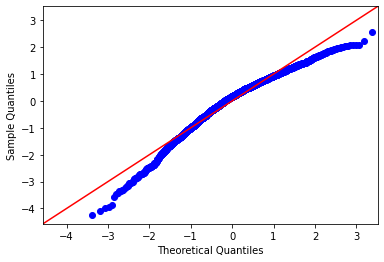

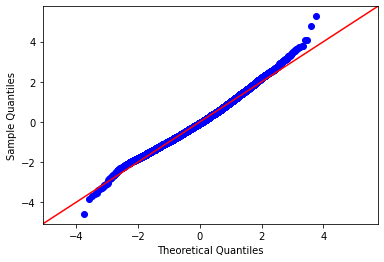

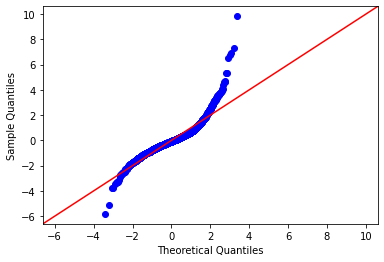

In [29]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 
                   'lat', 'long', 'sqft_living15', 'sqft_total', 'sqft_habitable', 'con2', 
                   'con4', 'con5', 'view1', 'view2', 'grd4', 'grd10', 'grd11', 'grd12', 'zip10', 'zip11', 'zip12', 
                   'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9',
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']

mediumincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 
                   'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 
                   'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'zip10', 'zip11', 'zip12', 
                   'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9',
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']

highincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 
                   'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 
                   'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'zip10', 'zip11', 'zip12', 
                   'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9',
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
make_ols(lowtier,lowincome)
make_ols(midtier,mediumincome)
make_ols(hightier,highincome)

## Refinement

In [36]:
kc_columns = ['price']

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable', 'con2', 'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4', 'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12', 'grd13', 'zip10', 'zip11', 'zip12', 'zip13', 'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80'], dtype='object')

In [31]:
for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2.25]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2.25)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

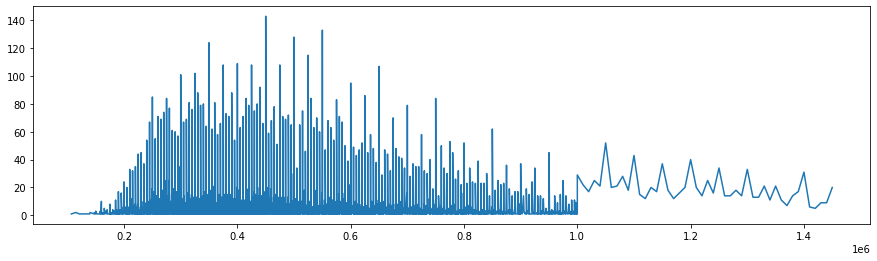

In [32]:
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index())

In [33]:
for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 191038.0
0.02 percentile: 210000.0
0.03 percentile: 221041.63999999998
0.04 percentile: 231500.0
0.05 percentile: 240000.0
0.06 percentile: 247500.0
0.07 percentile: 252000.0
0.08 percentile: 259500.0
0.09 percentile: 265000.0
0.1 percentile: 270000.0
0.11 percentile: 275000.0
0.12 percentile: 280000.0
0.13 percentile: 285000.0
0.14 percentile: 290000.0
0.15 percentile: 296000.0
0.16 percentile: 300000.0
0.17 percentile: 305806.0000000001
0.18 percentile: 312000.0
0.19 percentile: 317500.0
0.2 percentile: 323000.0
0.21 percentile: 327500.0
0.22 percentile: 332000.0
0.23 percentile: 337000.0
0.24 percentile: 342000.0
0.25 percentile: 348000.0
0.26 percentile: 350000.0
0.27 percentile: 356500.0
0.28 percentile: 360000.0
0.29 percentile: 368000.0
0.3 percentile: 374579.9999999999
0.31 percentile: 379000.0
0.32 percentile: 384000.0
0.33 percentile: 390000.0
0.34 percentile: 395000.0
0.35 percentile: 400000.0
0.36 percentile: 405000.0
0.37 percentile: 410000.0
0.38 percenti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.664e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:45:49   Log-Likelihood:                         -45915.
No. Observations:                3911   AIC:                                  9.187e+04
Df Residuals:                    3890   BIC:                                  9.200e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        4700.3828    738.588      6.364      0.000    3252.326    6148.439
bathrooms       1.298e+04   1451.056      8.943      0.000    1.01e+04    1.58e+04
floors          6019.3569   1314.077      4.581      0.000    3443.011    8595.703
lat             1.023e+05   4180.983     24.462      0.000    9.41e+04     1.1e+05
long            3.795e+04   1625.522     23.345      0.000    3.48e+04    4.11e+04
sqft_lot15         0.1443      0.042      3.443      0.001       0.062       0.226
sqft_total       5.91e-05   2.25e-05      2.625      0.009     1.5e-05       0.000
sqft_habitable     0.0076      0.001      5.948      0.000       0.005       0.010
view1           3.212e+04   7211.217      4.454      0.000     1.8e+04    4.63e+04
view2           1.455e+04   4200.649      3.463      0.001    6310.230    2.28e+04
view3           2.598e+04   6553.721      3.965      0.000    1.31e+04    3.88e+04
grd7            1.089e+04   1939.189      5.617      0.000    7091.188    1.47e+04
grd8            3.169e+04   2215.701     14.303      0.000    2.73e+04     3.6e+04
grd9            4.168e+04   4533.907      9.194      0.000    3.28e+04    5.06e+04
zip12           6859.2016   2589.075      2.649      0.008    1783.128    1.19e+04
zip13           9029.4221   2003.159      4.508      0.000    5102.080     1.3e+04
zip5            4516.6712   1720.442      2.625      0.009    1143.617    7889.725
zip7            1.348e+04   1592.149      8.467      0.000    1.04e+04    1.66e+04
zip8            1.736e+04   7024.480      2.471      0.014    3585.815    3.11e+04
zip9            4428.1988   1851.987      2.391      0.017     797.241    8059.157
thru80         -5433.8833   1248.286     -4.353      0.000   -7881.240   -2986.526
==============================================================================
Omnibus:                       40.277   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.072
Skew:                          -0.130   Prob(JB):                     1.79e-07
Kurtosis:                       2.650   Cond. No.                     5.21e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.961e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:45:49   Log-Likelihood:                         -51265.
No. Observations:                4312   AIC:                                  1.026e+05
Df Residuals:                    4292   BIC:                                  1.027e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       7443.3702   1398.586      5.322      0.000    4701.418    1.02e+04
lat             1.008e+05   4456.765     22.618      0.000    9.21e+04     1.1e+05
long            3.611e+04   1740.795     20.743      0.000    3.27e+04    3.95e+04
sqft_living15     12.3131      1.405      8.767      0.000       9.559      15.067
sqft_total      4.489e-05   7.69e-06      5.839      0.000    2.98e-05       6e-05
sqft_habitable     0.0048      0.001      4.771      0.000       0.003       0.007
view2           1.027e+04   3389.677      3.031      0.002    3627.472    1.69e+04
view3           1.616e+04   5200.062      3.108      0.002    5968.088    2.64e+04
grd9            1.918e+04   2355.968      8.141      0.000    1.46e+04    2.38e+04
grd10           3.704e+04   7457.275      4.967      0.000    2.24e+04    5.17e+04
zip10           2.083e+04   2686.433      7.752      0.000    1.56e+04    2.61e+04
zip11           1.499e+04   2328.238      6.437      0.000    1.04e+04    1.96e+04
zip2            1.581e+04   2471.935      6.396      0.000     1.1e+04    2.07e+04
zip3            -1.41e+04   2650.390     -5.319      0.000   -1.93e+04   -8901.943
zip6            6725.9320   2024.891      3.322      0.001    2756.098    1.07e+04
zip8            7305.7593   2685.842      2.720      0.007    2040.120    1.26e+04
thru2000       -2.111e+04   2530.404     -8.341      0.000   -2.61e+04   -1.61e+04
thru2020       -1.697e+04   2488.885     -6.817      0.000   -2.18e+04   -1.21e+04
thru60         -1.281e+04   2525.347     -5.073      0.000   -1.78e+04   -7859.771
thru80         -2.045e+04   2440.799     -8.378      0.000   -2.52e+04   -1.57e+04
==============================================================================
Omnibus:                      343.741   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.959
Skew:                           0.019   Prob(JB):                     4.88e-25
Kurtosis:                       2.211   Cond. No.                     1.13e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.13e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.583e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:45:49   Log-Likelihood:                         -51835.
No. Observations:                4244   AIC:                                  1.037e+05
Df Residuals:                    4222   BIC:                                  1.039e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        3624.4733   1041.395      3.480      0.001    1582.792    5666.155
bathrooms       6038.9055   1939.286      3.114      0.002    2236.885    9840.926
floors          6259.0298   1982.864      3.157      0.002    2371.572    1.01e+04
waterfront      5.639e+04   1.76e+04      3.196      0.001    2.18e+04     9.1e+04
lat             4.339e+04   7977.456      5.440      0.000    2.78e+04     5.9e+04
long            1.281e+04   3110.020      4.118      0.000    6709.502    1.89e+04
sqft_living15     25.6821      1.839     13.968      0.000      22.077      29.287
sqft_total      2.932e-05   7.91e-06      3.705      0.000    1.38e-05    4.48e-05
sqft_habitable     0.0034      0.001      2.848      0.004       0.001       0.006
zip12          -1.647e+04   3144.278     -5.239      0.000   -2.26e+04   -1.03e+04
zip13          -2.657e+04   4563.502     -5.822      0.000   -3.55e+04   -1.76e+04
zip2           -8511.3193   3262.140     -2.609      0.009   -1.49e+04   -2115.809
zip3           -4.554e+04   5152.533     -8.839      0.000   -5.56e+04   -3.54e+04
zip4           -1.753e+04   3193.278     -5.490      0.000   -2.38e+04   -1.13e+04
zip5           -2.052e+04   3558.303     -5.767      0.000   -2.75e+04   -1.35e+04
zip6           -1.131e+04   3363.984     -3.362      0.001   -1.79e+04   -4713.783
zip7           -3.148e+04   3540.755     -8.889      0.000   -3.84e+04   -2.45e+04
zip8           -7975.3575   3348.521     -2.382      0.017   -1.45e+04   -1410.494
thru2000       -2.122e+04   3338.798     -6.355      0.000   -2.78e+04   -1.47e+04
thru2020         -2.1e+04   3341.234     -6.287      0.000   -2.76e+04   -1.45e+04
thru60         -7265.6165   3023.023     -2.403      0.016   -1.32e+04   -1338.900
thru80         -2.424e+04   3100.676     -7.818      0.000   -3.03e+04   -1.82e+04
==============================================================================
Omnibus:                      515.297   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.978
Skew:                           0.161   Prob(JB):                     9.96e-34
Kurtosis:                       2.130   Cond. No.                     2.69e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.69e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          1.260e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:45:50   Log-Likelihood:                         -46346.
No. Observations:                3593   AIC:                                  9.273e+04
Df Residuals:                    3573   BIC:                                  9.286e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.683e+04   1618.046     10.404      0.000    1.37e+04       2e+04
bathrooms       1.683e+04   1618.046     10.404      0.000    1.37e+04       2e+04
floors          1.469e+04   3923.808      3.743      0.000    6994.833    2.24e+04
waterfront      6.579e+04   2.17e+04      3.038      0.002    2.33e+04    1.08e+05
yr_renovated      13.8131      3.578      3.861      0.000       6.798      20.828
lat            -7.711e+04   2.28e+04     -3.377      0.001   -1.22e+05   -3.23e+04
long           -3.488e+04   8894.132     -3.921      0.000   -5.23e+04   -1.74e+04
sqft_living15     58.4670      3.094     18.896      0.000      52.401      64.533
sqft_habitable     0.0051      0.002      2.960      0.003       0.002       0.009
view2           1.728e+04   5865.840      2.946      0.003    5778.292    2.88e+04
grd4            4.805e-11    1.9e-11      2.528      0.012    1.08e-11    8.53e-11
zip11          -1.651e+04   6339.923     -2.604      0.009   -2.89e+04   -4077.532
zip12          -5.159e+04   8162.892     -6.320      0.000   -6.76e+04   -3.56e+04
zip13           -8.02e+04   1.28e+04     -6.243      0.000   -1.05e+05    -5.5e+04
zip14          -1.826e+04   8143.451     -2.242      0.025   -3.42e+04   -2295.245
zip2           -5.632e+04   6829.512     -8.246      0.000   -6.97e+04   -4.29e+04
zip3           -6.722e+04   1.63e+04     -4.123      0.000   -9.92e+04   -3.53e+04
zip4           -1.047e+05   8109.107    -12.906      0.000   -1.21e+05   -8.88e+04
zip5           -3.256e+04   7728.146     -4.213      0.000   -4.77e+04   -1.74e+04
zip6           -5.531e+04   6097.581     -9.070      0.000   -6.73e+04   -4.34e+04
zip7           -1.299e+05      1e+04    -12.955      0.000    -1.5e+05    -1.1e+05
zip8           -8.179e+04   6719.360    -12.172      0.000    -9.5e+04   -6.86e+04
==============================================================================
Omnibus:                      167.395   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.915
Skew:                           0.555   Prob(JB):                     9.50e-42
Kurtosis:                       2.826   Cond. No.                     1.94e+23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.71e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

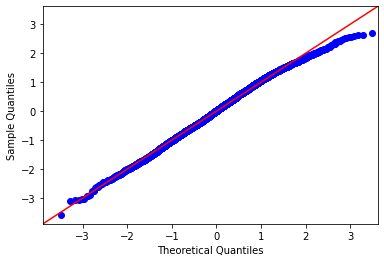

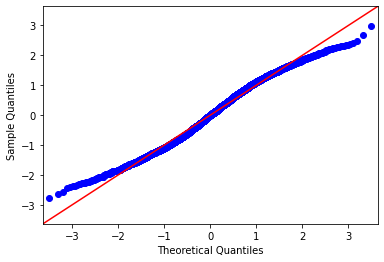

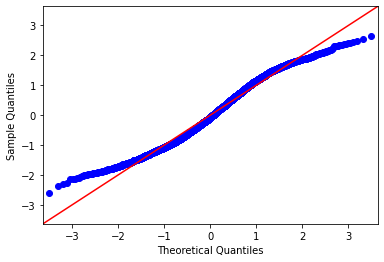

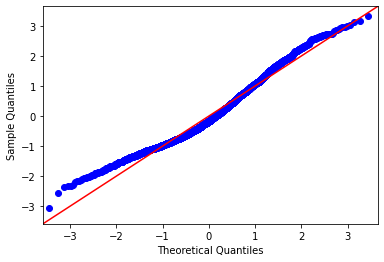

In [154]:
lowtier = kc_data[(kc_data.price > 210000) & (kc_data.price<=348000) ]
midtier = kc_data[(kc_data.price > 348000) & (kc_data.price<=480000) ]
uppermidtier = kc_data[(kc_data.price > 480000) & (kc_data.price<=664000) ]
hightier = kc_data[(kc_data.price >664000) & (kc_data.price<=1080000)]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'lat', 'long', 'sqft_lot15', 'sqft_total', 
             'sqft_habitable',  'view1', 'view2', 'view3',  'grd7', 'grd8', 'grd9', 'zip12', 
             'zip13', 'zip5',  'zip7', 'zip8', 'zip9', 'thru80']


mediumincome = ['bathrooms', 'lat', 'long', 'sqft_living15',  'sqft_total', 'sqft_habitable', 
              'view2', 'view3', 'grd9', 'grd10', 'zip10', 'zip11', 'zip2', 'zip3', 'zip6', 'zip8',
              'thru2000', 'thru2020', 'thru60', 'thru80']

uppermedincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'lat', 'long', 'sqft_living15',
                  'sqft_total', 'sqft_habitable', 'zip12', 'zip13', 'zip2', 'zip3', 'zip4', 'zip5',
                  'zip6', 'zip7', 'zip8', 'thru2000', 'thru2020', 'thru60', 'thru80']

highincome = ['bathrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 'lat', 'long', 
              'sqft_living15','sqft_habitable', 'view2', 'grd4','zip11', 'zip12', 'zip13', 
              'zip14', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res


make_ols(lowtier,lowincome)
make_ols(midtier,mediumincome)
make_ols(uppermidtier,uppermedincome)
make_ols(hightier,highincome)

In [ ]:
lowtier.corr() > .

## Train Split Test - High Tier

In [155]:
print(type(hightier))

<class 'pandas.core.frame.DataFrame'>


In [156]:
y = hightier[['price']]
X = hightier.drop(['price'], axis=1)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2874 719 2874 719


In [159]:
print(X_train)

       bedrooms  bathrooms  floors  waterfront  yr_renovated      lat     long  sqft_living15  sqft_lot15  sqft_total  sqft_habitable  con2  con3  con4  con5  view1  view2  view3  view4  grd4  grd5  grd6  grd7  grd8  grd9  grd10  grd11  grd12  grd13  zip10  zip11  zip12  zip13  zip14  zip2  zip3  zip4  zip5  zip6  zip7  zip8  zip9  thru2000  thru2020  thru40  thru60  thru80
21043         5       3.00     1.0         0.0             0  47.5090 -122.240           2270        7623    22588390       2460191.0     0     1     0     0      0      1      0      0     0     0     0     0     0     1      0      0      0      0      0      0      0      0      1     0     0     0     0     0     0     0     0         0         1       0       0       0
15264         4       2.50     2.0         0.0             0  47.6874 -122.161           3220        5083    13856700          3231.0     0     1     0     0      0      0      0      0     0     0     0     0     0     1      0      0      0    

In [160]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [161]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [162]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    8.025529e+09
dtype: float64
Test Mean Squarred Error: price    8.828740e+09
dtype: float64


In [163]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 8025529128.343818
Test Mean Squarred Error: 8828740387.570007


In [164]:
linreg.score(X_test, y_test)

0.3029743592469525

## Train Split Test - Medium Tier

In [7]:
y = midtier[['price']]
X = midtier.drop(['price'], axis=1)

NameError: name 'midtier' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

NameError: name 'X_train' is not defined

In [3]:
print(X_train)

NameError: name 'X_train' is not defined

In [4]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

NameError: name 'LinearRegression' is not defined

In [5]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

NameError: name 'y_hat_train' is not defined

In [6]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

NameError: name 'np' is not defined

In [ ]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print('Diff:', test_mse-train_mse)


In [ ]:
linreg.score(X_test, y_test)

## Train Split Test - Low Tier

In [ ]:
y = lowtier[['price']]
X = lowtier.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
print(X_train)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [ ]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

In [ ]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

In [ ]:
linreg.score(X_test, y_test)

In [ ]:
x_cols =['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable',
       'con2', 'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4',
       'grd4', 'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11',
       'grd12', 'grd13']

In [ ]:
X = kc_data[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

# Interpret

In [ ]:
model.summary()

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
kc_data = kc_data.sort_values('coef', ascending=False)
kc_data.head(15)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=df_renovated)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=df_renovated)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=df_renovated)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=df_renovated)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=df_renovated)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_living', y='price', data=df_renovated)
ax.set(title='Square Feet Living Space & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_above', y='price', data=df_renovated)
ax.set(title='Square Feet Above & Price', 
       xlabel='Sqft. Above', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=df_renovated)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=df_renovated)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

In [ ]:
df_renovated=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_renovated['pairs'] = list(zip(df_renovated.level_0,df_renovated.level_1)
df_renovated.set_index(['pairs'], inplace = True)
df_renovated.drop(columns=['level_1','level_0'], inplace = True)
df_renovated.columns = ['cc']
df.drop_ducplicates(inplace=True)

In [ ]:
df_renovated[(df.cc>.75) & (df.cc <1)]

# Conclusions & Recommendations

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


X = kc_data.drop('price', axis=1)
y = kc_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ols1 = LinearRegression()
ols1.fit(X_train, y_train)

predprice = ols1.predict(y_train)

np.sqrt(mean_squared_error(X_train, predprice))

ols2 = LinearRegression()
ols_cv_mse = cross_val_score(ols2, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
ols_cv_mse.mean()


In [ ]:
mean_squared_error(y_train, predprice)